<h1><center> Optimization, Alignment and Fine-tuning for LLMs - Part II</center></h1>

# Objective

To illustrate how Direct Preference Optimization (DPO) could be used to align a supervised fine-tuned (SFT) model to human preference.

# Concept Review

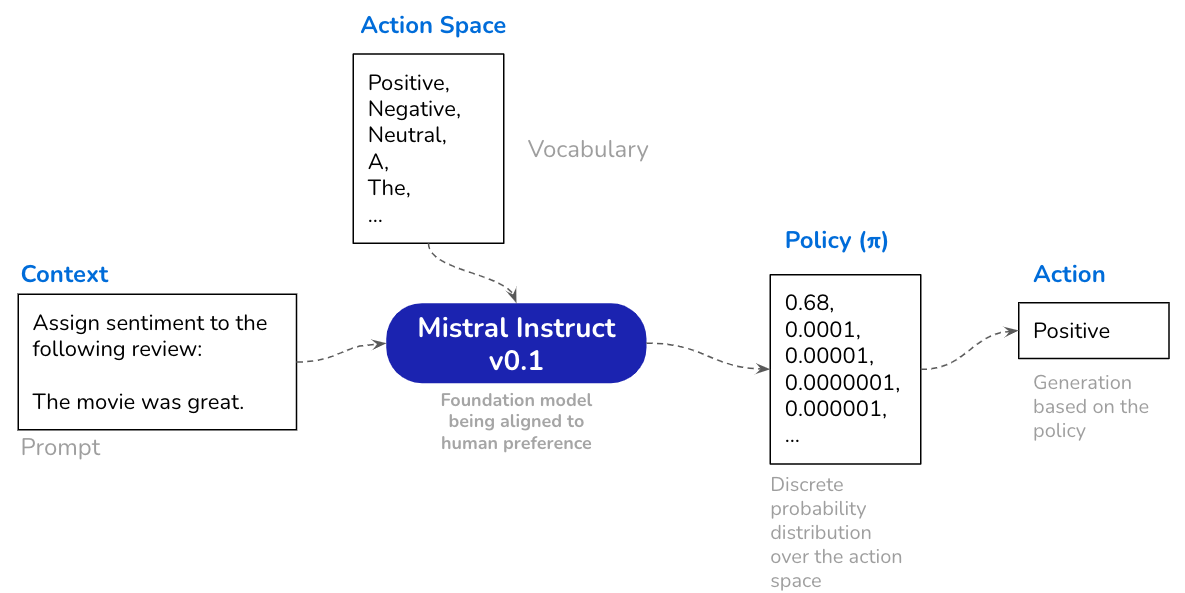

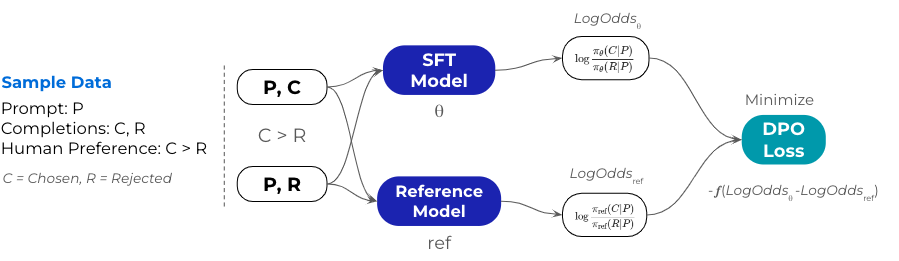

As the above figure indicates, given an empirical dataset $D$, minimizing the DPO loss allows us to determine the best policy $\pi$ that pushes the SFT model more towards the chosen responses.

The DPO loss is (Source: *Direct Preference Optimization: Your Language Model is Secretly a Reward Model.* https://arxiv.org/abs/2305.18290):

$$
\min_{\pi} \mathbf{E}_{(P, C, R) \sim D} \left[-\log \sigma \left( \beta \log \dfrac{\pi_{\theta}(C | P)}{\pi_{\text{ref}}(C | P)} - \beta \log \dfrac{\pi_{\theta}(R | P)}{\pi_{\text{ref}}(R | P)}\right )\right]
$$

where $\log \sigma(x) = \log \left( \dfrac{1}{1 + e^{-x}} \right)$ refers to the log sigmoid function.

We can define specific components of this loss function as implicit reward functions like so (we track these individual components during training):

- `logits_chosen` $ = \log \dfrac{\pi_{\theta}(C | P)}{\pi_{\text{ref}}(C | P)}$

- `logits_rejected` $ = \log \dfrac{\pi_{\theta}(R | P)}{\pi_{\text{ref}}(R | P)}$

- `rewards_chosen` $ = \beta$ `logits_chosen`

- `rewards_rejected` $ = \beta$ `logits_rejected`

- `rewards_margins` = `rewards_chosen` - `rewards_rejected`



# Setup

In [ ]:
#@title Run this cell to setup Unsloth on Colab
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 84.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [ ]:
# Importing PyTorch, an open-source machine learning library based on Torch, used for applications such as computer vision and 
# natural language processing.
import torch

# Importing the `load_dataset` function from the `datasets` package, which provides a simple way to download and load various 
# datasets for machine learning experiments.
from datasets import load_dataset

# Importing the `PatchDPOTrainer` class from the `unsloth` package. This class likely implements a training loop for a model 
# using Direct Preference Optimization (DPO) techniques, specifically tailored for patch-based models.
from unsloth import PatchDPOTrainer

# Importing the `FastLanguageModel` class from the `unsloth` package. This class probably defines a fast implementation of a 
# language model that can be trained or fine-tuned using the previously imported `PatchDPOTrainer`.
from unsloth import FastLanguageModel

# Importing the `TrainingArguments` class from the `transformers` package. This class is used to define the training arguments 
# for models in the Hugging Face Transformers library, specifying parameters like learning rate, batch size, number of epochs etc
from transformers import TrainingArguments

# Importing the `DPOTrainer` class from the `trl` package. This class seems to implement a training loop for models using 
# Direct Preference Optimization (DPO), similar to the `PatchDPOTrainer` but possibly offering a broader range of features 
# or optimizations.
from trl import DPOTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


The functionalities we use from the above packages are:
- `datasets`: helpers to load datasets from the HuggingFace ecosystem
- `transformers`: abstractions for training arguments
- `unsloth`: facilitates application of DPO in conjunction with peft on 4-bit quantized base models
- `trl`: abstractions to execute alignment fine-tuning using DPO

# Data

The dataset used in this notebook to create an aligne model is the Ultra Feedback dataset (Source: https://huggingface.co/datasets/HuggingFaceH4/ultrafeedback_binarized) that comprises a prompt and two responses labeled "chosen" and "rejected" using ratings from GPT4. A sample of the dataset is hosted on HuggingFace for easy access (https://huggingface.co/datasets/pgurazada1/ultrafeedback-sample).

We begin by loading the dataset.

In [ ]:
dataset = load_dataset("pgurazada1/ultrafeedback-sample")

Generating train split:   0%|          | 0/305 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
len(dataset['train']), len(dataset['test'])

(305, 10)

Let us inspect a sample from the formatted dataset.

In [ ]:
dataset['train'][0]

{'chosen': "In this metaphor, Thoreau is suggesting that if a person doesn't conform or fit in with others around them, it might be because they have their own unique path and aspirations. He encourages the individual to follow their own internal guidance and passions, no matter how different or distant it may seem from the norm.\n\nThoreau's metaphors can still apply to readers today, as it highlights the importance of individuality and staying true to oneself in a world that often values conformity.</s>\n",
 'rejected': "Thoreau is comparing a person who marches to the beat of their own drummer to a band that plays at a different tempo. He suggests that if someone is falling behind their peers, it might be because they are listening to a different internal rhythm. He encourages them to follow their own internal beat rather than trying to force themselves to keep up with others. Whether or not this metaphor applies to readers today depends on their individual lifestyles and personalit

As the above output indicates, we have a `prompt` and two completions marked as `chosen` and `rejected` for each such prompt in the dataset. The prompt follows a specific prompt template with `system`, `user` and `asssistant` messages.

In [ ]:
print(dataset['train'][0]['prompt'])

<|system|>
</s>
<|user|>
Thoreau’s metaphors are highly visual. Though they’re clever and original, they aren’t far-fetched. Thoreau takes his comparisons from nature and from other things with which he and his audience are familiar. To be sure you understand Thoreau’s figures of speech, paraphrase the following metaphor. Do his metaphors apply to readers today?

“If a man does not keep pace with his companions, perhaps it is because he hears a different drummer. Let him step to the music which he hears, however measured or far away.”</s>
<|assistant|>



# Model

To illustrate the process of using DPO to align SFT models, we start with the zephyr SFT model (4-bit quantized). This model is essentially 4-bit quantized version of Mistral model v0.2 (without alignment finetuning).

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/zephyr-sft-bnb-4bit",
    max_seq_length=4096,
    dtype=None,
    load_in_4bit=True
)

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

unsloth/zephyr-sft-bnb-4bit does not have a padding token! Will use pad_token = <unk>.


In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (

Let us run a sample inference:

In [ ]:
FastLanguageModel.for_inference(model)

In [ ]:
prompt = """<|system|>
Assign sentiment to the movie review in the input.</s>
<|user|>
### Review:
I saw this movie few days back. To be honest I wasn't even aware that such a movie existed. It was only when this was sent as an official entry from India and it was all over the news, that I came to know of its existence. Maybe the movie wasn't advertised or marketed well.

It is such an awesome movie that I find it a crime that this movie wasn't known to me.</s>
<|assistant|>
"""

In [ ]:
inputs = tokenizer(
    [prompt],
    return_tensors="pt"
).to("cuda")

In [ ]:
outputs = model.generate(
    **inputs,
    max_new_tokens=24,
    temperature=0,
    use_cache=True,
    pad_token_id=tokenizer.eos_token_id
)

In [ ]:
print(
    tokenizer.decode(
        outputs[0][inputs.input_ids.shape[-1]:],
        skip_special_tokens=True,
        cleanup_tokenization_spaces=True
    )
)

The sentiment of the review is positive.


As we can see from the output above, the model understands instructions (since SFT is done) but it needs to go through human preference alignment using DPO.

# DPO

Since we want to keep the alignment fine-tuning within the free tier limits of Colab, we perform DPO on the PEFT variant of the model. If GPU time limits are not an issue, DPO could be performed on the full model itself.

## Load the PEFT model

In [ ]:
# Initialize a PEFT (Positional Encoding Free Transformer) model with specific configurations
model = FastLanguageModel.get_peft_model(
    # The base model to which PEFT modifications will be applied
    model,
    
    # Number of heads in the multi-head attention mechanism
    r=64,
    
    # List of module names to apply PEFT modifications to
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    
    # Parameter controlling the strength of LoRA (Low-Rank Adaptation) regularization
    lora_alpha=64,
    
    # Dropout rate for LoRA layers; set to 0 for no dropout
    lora_dropout=0,
    
    # Bias initialization strategy; options could include 'none', 'zeros', etc.
    bias="none",
    
    # Enable gradient checkpointing to reduce memory usage during training
    use_gradient_checkpointing=True,
    
    # Seed for reproducibility of experiments
    random_state=42,
    
    # Configuration for LoftQ (Layer-wise Orthogonal Feature Transformation), if applicable
    loftq_config=None
)

Unsloth 2024.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=

## Training using DPO

In [ ]:
PatchDPOTrainer()

In [ ]:
# Create an instance of DPOTrainer for distributed parallel optimization training
dpo_trainer = DPOTrainer(
    # The model to be trained
    model=model,
    
    # Reference model for knowledge distillation or other comparison purposes; None indicates no reference
    ref_model=None,
    
    # Training arguments configuration
    args=TrainingArguments(
        # Batch size per device for training data
        per_device_train_batch_size=2,
        
        # Batch size per device for evaluation data
        per_device_eval_batch_size=2,
        
        # Number of steps to accumulate gradients over before performing an update
        gradient_accumulation_steps=4,
        
        # Ratio of initial learning rate to final learning rate during warm-up phase
        warmup_ratio=0.1,
        
        # Total number of epochs to train for
        num_train_epochs=3,
        
        # Strategy for evaluating the model; 'epoch' means evaluate after each epoch
        evaluation_strategy="epoch",
        
        # Strategy for saving the model; 'epoch' means save after each epoch
        save_strategy="epoch",
        
        # Learning rate for the optimizer
        learning_rate=5e-6,
        
        # Whether to use mixed precision training (FP16); automatically determined based on hardware support
        fp16=not torch.cuda.is_bf16_supported(),
        
        # Whether to use BF16 precision; automatically determined based on hardware support
        bf16=torch.cuda.is_bf16_supported(),
        
        # Frequency of logging training metrics
        logging_steps=1,
        
        # Optimizer type; 'paged_adamw_8bit' suggests using a custom or specialized optimizer
        optim="paged_adamw_8bit",
        
        # Weight decay (L2 regularization)
        weight_decay=0.0,
        
        # Type of learning rate scheduler
        lr_scheduler_type="linear",
        
        # Random seed for reproducibility
        seed=42,
        
        # Directory to save outputs such as model checkpoints and logs
        output_dir="outputs",
        
        # Whether to remove unused columns in the dataset
        remove_unused_columns=False
    ),
    
    # Beta parameter for the DPO algorithm, influencing the balance between exploration and exploitation
    beta=0.1,
    
    # Loss type; 'sigmoid' for standard sigmoid cross-entropy, 'ipo' for IPO (Influence-Preserving Optimization)
    loss_type='sigmoid',
    
    # Dataset for training
    train_dataset=dataset["train"],
    
    # Dataset for evaluation
    eval_dataset=dataset["test"],
    
    # Tokenizer for text processing
    tokenizer=tokenizer,
    
    # Maximum sequence length allowed in the input data
    max_length=1024,
    
    # Maximum prompt length for generating responses or prompts
    max_prompt_length=512
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/305 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

A key hyperparameter is $\beta$ that controls the regularization applied to control changes in policy as the loss minimization occurs. High $\beta$ restricts the fine-tuned model to deviate lesser from the reference model. Typical values of $\beta$ are between 0.1 and 0.5. Also, note that we are marking the `ref_model=None` to indicate that at the start of training, both the SFT model and the reference model are the same. During training, the SFT model will be nudged to increase the log odds of selecting chosen responses as opposed to rejected responses.

The parameter `loss_type` specifies the type of DPO loss to be used. The default is the `sigmoid` loss (see equation above). Specifying `loss_type='ipo'` switches the loss to the IPO loss.  

We compute the individual components of the loss function as before and use these metrics to monitor training progress.

In [ ]:
dpo_trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 305 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 114
 "-____-"     Number of trainable parameters = 167,772,160
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen


Indications of good training progress.
- Gradual decrease in training loss and validation loss.
- Reward margins gradually increase indicating that the model is increasingly producing the chosen completions over the rejected completions.